# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/'My Drive/Transsight/QSR'
%ls

Mounted at /content/drive
/content/drive/My Drive/Transsight/QSR
Churn_prediction.ipynb  data/  docs/  QRS_EDA.ipynb  RFM.ipynb


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# EDA

## Product data

### Read data

In [ ]:
product_df = pd.read_csv("data/ProductData -masked.csv")
product_df['Date'] = pd.to_datetime(product_df["Actual Date"])
print("Number of rows : ", len(product_df))
product_df.head(2)

Number of rows :  59154


,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date,Date
0,9870XXXX53606,711863273,HYDERABAD/SECUNDERABAD,0171-6208991 WebMobile,84258674,310128,14 May 18,2018-05-14
1,9870XXXX51763,716686990,NaN,NaN,84258093,310128,27 May 18,2018-05-27


### Basic Info

##### Duplicates

In [ ]:
product_df[product_df.duplicated(keep=False)].head(4)

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date


##### Null values

In [ ]:
count=product_df.isnull().sum().sort_values(ascending=False)
ratio=count/len(product_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
city,23479,0.396913
ONLINE_ORDER_TYPE,20774,0.351185
Date,0,0.000000
Actual Date,0,0.000000
menuItemPOSRef,0,0.000000
recordID,0,0.000000
CHECK_ID,0,0.000000
CONTACT_NUMBER,0,0.000000


#### Unique values

In [ ]:
product_df.nunique()

CONTACT_NUMBER       59154
CHECK_ID             59154
city                   721
ONLINE_ORDER_TYPE    38380
recordID               917
menuItemPOSRef           5
Actual Date             52
Date                    52
dtype: int64

### How many types of ONLINE_ORDER_TYPE are there?

In [ ]:
product_df['ONLINE_ORDER_TYPE_text'] = product_df.loc[~product_df.ONLINE_ORDER_TYPE.isna()].ONLINE_ORDER_TYPE.astype(str).str.replace('[^a-zA-Z]', ' ').str.strip()
product_df.head(2)

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date,Date,ONLINE_ORDER_TYPE_text
0,9870XXXX53606,711863273,HYDERABAD/SECUNDERABAD,0171-6208991 WebMobile,84258674,310128,14 May 18,2018-05-14,WebMobile
1,9870XXXX51763,716686990,NaN,NaN,84258093,310128,27 May 18,2018-05-27,NaN


In [ ]:
product_df.ONLINE_ORDER_TYPE_text.unique()

array(['WebMobile', nan, 'mobile app', 'Zomato', 'Call center',
       'Food Panda', 'mycentral Website', 'Facebook'], dtype=object)

In [ ]:
product_df.ONLINE_ORDER_TYPE_text.nunique()

7

### Repeated vs Non-repeated columns

#### CHECK_ID

In [ ]:
temp_check_df = product_df.groupby('CHECK_ID').agg({'CHECK_ID': 'count'})
temp_check_df.loc[temp_check_df.CHECK_ID > 1]

,CHECK_ID
CHECK_ID,


#### CONTACT_NUMBER

In [ ]:
temp_contact_df = product_df.groupby('CONTACT_NUMBER').agg({'CONTACT_NUMBER': 'count'})
temp_contact_df.loc[temp_contact_df.CONTACT_NUMBER > 1]

,CONTACT_NUMBER
CONTACT_NUMBER,


#### recordID

In [ ]:
temp_record_df = product_df.groupby('recordID').agg({'recordID': 'count'})
temp_record_df.loc[temp_record_df.recordID > 1]

,recordID
recordID,
82642019,7
82642020,14
82642176,4
82642177,27
82642569,328
...,...
84263176,62
84263178,2
84263954,13


#### Date

In [ ]:
temp_date_df = product_df.groupby('Date').agg({'Date': 'count'})
temp_date_df.loc[temp_date_df.Date > 1]

,Date
Date,
2018-04-06,594
2018-04-07,699
2018-04-08,973
2018-04-09,440
2018-04-10,634
2018-04-11,1940
2018-04-12,788
2018-04-13,986
2018-04-14,1080


### Check Id per ONLINE_ORDER_TYPE

In [ ]:
product_df.loc[product_df.ONLINE_ORDER_TYPE_text == 'Facebook']

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date,Date,ONLINE_ORDER_TYPE_text
4668,9870XXXX56807,701122579,Delhi,0109-5869356 Facebook,84258455,310128,16 Apr 18,2018-04-16,Facebook
8891,9870XXXX18304,710427324,Delhi,0188-6156653 Facebook,82645499,401006,10 May 18,2018-05-10,Facebook
17518,9870XXXX17569,707860595,Jalandhar,0212-6077143 Facebook,82643705,401006,3 May 18,2018-05-03,Facebook
20905,9870XXXX46489,712751622,Bengaluru,0086-6237686 Facebook,84256985,310128,16 May 18,2018-05-16,Facebook
23683,9870XXXX8909,705254742,Haldwani,0371-6000459 Facebook,83775726,401006,27 Apr 18,2018-04-27,Facebook
42185,9870XXXX1602,701654164,Punjab,0331-5879198 Facebook,84240652,401007,17 Apr 18,2018-04-17,Facebook


#### Total Number of unique [Contact number, Check id, Record Id, menuItem] per channel

In [ ]:
product_df.groupby('ONLINE_ORDER_TYPE_text').agg({'CONTACT_NUMBER': pd.Series.nunique, 
                                                  'CHECK_ID': pd.Series.nunique, 
                                                  'recordID': pd.Series.nunique, 
                                                  'menuItemPOSRef': pd.Series.nunique,
                                                  'city': pd.Series.nunique})

,CONTACT_NUMBER,CHECK_ID,recordID,menuItemPOSRef,city
ONLINE_ORDER_TYPE_text,,,,,
Call center,12056,12056,659,5,419
Facebook,6,6,6,3,5
Food Panda,1645,1645,316,5,283
WebMobile,5973,5973,571,5,43
Zomato,10004,10004,283,5,7
mobile app,5939,5939,630,5,46
mycentral Website,2757,2757,552,5,79


### CHECK_ID and ONLINE_ORDER_TYPE_text mapping

In [ ]:
temp_check_channel_df = product_df.groupby('CHECK_ID').agg({'ONLINE_ORDER_TYPE_text': pd.Series.nunique})
count = temp_check_channel_df.ONLINE_ORDER_TYPE_text.value_counts()
ratio=count/len(temp_check_channel_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
1,38380,0.648815
0,20774,0.351185


### Trying to find what columns will be used as Customer Id, Transaction Id, Product Id

In [ ]:
product_df.head(2)

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date,Date
0,9870XXXX53606,711863273,HYDERABAD/SECUNDERABAD,0171-6208991 WebMobile,84258674,310128,14 May 18,2018-05-14
1,9870XXXX51763,716686990,NaN,NaN,84258093,310128,27 May 18,2018-05-27


#### Can CONTACT_NUMBER be used as Customer Id

In [ ]:
product_df.groupby(['CONTACT_NUMBER']).agg({'Date': 'count', 'CHECK_ID': 'count', 'recordID': 'count'}).head(3)

,Date,CHECK_ID,recordID
CONTACT_NUMBER,,,
9870XXXX01,1,1,1
9870XXXX02,1,1,1
9870XXXX03,1,1,1


In [ ]:
product_df.groupby(['CONTACT_NUMBER']).agg({'Date': 'count', 'CHECK_ID': 'count', 'recordID': 'count'}).nunique()

Date        1
CHECK_ID    1
recordID    1
dtype: int64

No, because Each CONTACT_NUMBER apprears only once on a particular date.

#### Can CHECK_ID be used as Customer Id

In [ ]:
product_df.groupby(['CHECK_ID']).agg({'Date': 'count', 'recordID': 'count', 'menuItemPOSRef': 'count'}).head(3)

,Date,recordID,menuItemPOSRef
CHECK_ID,,,
697365617,1,1,1
697367101,1,1,1
697367377,1,1,1


In [ ]:
product_df.groupby(['CHECK_ID']).agg({'Date': 'count', 'recordID': 'count', 'menuItemPOSRef': 'count'}).nunique()

Date              1
recordID          1
menuItemPOSRef    1
dtype: int64

No, because Each CHECK_ID apprears only once on a particular date.

#### Can recordID be used as Transaction Id

In [ ]:
product_df.groupby(['recordID']).agg({'Date': pd.Series.nunique, 'menuItemPOSRef': 'count'})

,Date,menuItemPOSRef
recordID,,
82642019,7,7
82642020,13,14
82642176,4,4
82642177,23,27
82642569,47,328
...,...,...
84263176,25,62
84263178,2,2
84263954,7,13


In [ ]:
product_df.loc[product_df.recordID == 82642019]

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date,Date
7837,9870XXXX17318,708478442,HYDERABAD/SECUNDERABAD 500049,0298-6095207 Food Panda,82642019,401006,5 May 18,2018-05-05
31129,9870XXXX11154,703206957,HYDERABAD/SECUNDERABAD 500072,0298-5939367 Food Panda,82642019,401006,22 Apr 18,2018-04-22
32861,9870XXXX9634,700803249,HYDERABAD/SECUNDERABAD,0298-5866120 Food Panda,82642019,401006,15 Apr 18,2018-04-15
36650,9870XXXX10388,705965457,HYDERABAD/SECUNDERABAD,0298-6026490 Food Panda,82642019,401006,29 Apr 18,2018-04-29
47050,9870XXXX5312,710124990,HYDERABAD/SECUNDERABAD,0298-6148367 Food Panda,82642019,401006,9 May 18,2018-05-09
51130,9870XXXX4233,716649378,HYDERABAD/SECUNDERABAD,0298-6358922 Food Panda,82642019,401006,27 May 18,2018-05-27
54816,9870XXXX2845,716053916,HYDERABAD/SECUNDERABAD,0298-6339929 Food Panda,82642019,401006,25 May 18,2018-05-25


No because Transaction Id should have unique date per transaction


#### Checking relation between CHECK_ID and recordID presuming recordID as Customer Id

In [ ]:
product_df.groupby(['recordID']).agg({'Date': pd.Series.nunique, 'CHECK_ID': pd.Series.nunique, 'menuItemPOSRef': 'count'})

,Date,CHECK_ID,menuItemPOSRef
recordID,,,
82642019,7,7,7
82642020,13,14,14
82642176,4,4,4
82642177,23,27,27
82642569,47,328,328
...,...,...,...
84263176,25,62,62
84263178,2,2,2
84263954,7,13,13


Not sure. But recordID can be used as Customer Id and CHECK_ID can be used Transaction Id.

### Insights

- There are 7 channels in the data 
- CONTACT_NUMBER and CHECK_ID is one to one mapping - IMPORTANT
- Except CONTACT_NUMBER and CHECK_ID all other columns are repeated
- 64.88% CHECK_ID has only one ONLINE_ORDER_TYPE_text i.e one-to-one mapping present in the data  - IMPORTANT
- We don't know ONLINE_ORDER_TYPE_text for 35.11% of CHECK_ID
- ONLINE_ORDER_TYPE has 2 fields - Contact number and Order type. Contact number could be different for different areas in the same city.

### Queries

- What is CHECK_ID is used for? Does each user has unique CHECK_ID?
- What does recordID and menuItemPOSRef represent?

### Pending

- CHECK_ID and recordID mapping
- ONLINE_ORDER_TYPE and recordID mapping

## Transaction data

In [ ]:
trans_df = pd.read_csv("data/TransactionData - masked.csv")
trans_df['Transaction_date'] = pd.to_datetime(trans_df["Transaction Date"])
trans_df['Last_update_date'] = pd.to_datetime(trans_df["Last Update"])
print("Number of rows : ", len(trans_df))
trans_df.head(2)

Number of rows :  846369


,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount,Transaction_date,Last_update_date
0,386191,727585634,NaN,23 Jun 18,9821XXXX691,23 Jun 18,Dine In,2506,200.34,2018-06-23,2018-06-23
1,111063,721708340,MOHALI,8 Jun 18,9821XXXX718,8 Jun 18,Mobile App,7499,234.30,2018-06-08,2018-06-08


### Basic Info

##### Duplicates

In [ ]:
trans_df[trans_df.duplicated(keep=False)].head(4)

,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount,Transaction_date,Last_update_date


##### Null values

In [ ]:
count=trans_df.isnull().sum().sort_values(ascending=False)
ratio=count/len(trans_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
city,605971,0.715965
channelId,3759,0.004441
Last_update_date,0,0.000000
Transaction_date,0,0.000000
TotalAmount,0,0.000000
CheckNo,0,0.000000
Last Update,0,0.000000
MobileNo,0,0.000000
Transaction Date,0,0.000000
GuestcheckId,0,0.000000


#### Unique values

In [ ]:
trans_df.nunique()

CustomerID          517052
GuestcheckId        846369
city                   109
Transaction Date        57
MobileNo            711404
Last Update             57
channelId               10
CheckNo               9000
TotalAmount          83334
Transaction_date        57
Last_update_date        57
dtype: int64

### CustomerID and GuestcheckId mapping

In [ ]:
temp_custid_checkid_df = trans_df.groupby('CustomerID').agg({'GuestcheckId': pd.Series.nunique})
count = temp_custid_checkid_df.GuestcheckId.value_counts()
ratio=count/len(temp_custid_checkid_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
2,329317,0.636913
1,187735,0.363087


### Check if Transaction_date and Last_update_date is same

In [ ]:
trans_df['Transaction_date'].equals(trans_df['Last_update_date'])

True

### How many types of channelId are there?

In [ ]:
trans_df.channelId.unique()

array(['Dine In', 'Mobile App', 'Call center', 'Zomato', 'WebMobile', nan,
       'Food Panda', 'website', 'ONLINE', 'Web native', 'Facebook'],
      dtype=object)

In [ ]:
trans_df.channelId.nunique()

10

### channelId Penetration

In [ ]:
trans_unique_df = trans_df.groupby('channelId').agg({'CustomerID': pd.Series.nunique, 
                                   'Transaction_date': pd.Series.nunique,
                                   'city': pd.Series.nunique,
                                   'TotalAmount': 'sum'})
trans_unique_df = trans_unique_df.reset_index()
trans_unique_df['TotalAmount_in_Millions'] = trans_unique_df.TotalAmount / 1000000
trans_unique_df['CustomerID_in_K'] = trans_unique_df.CustomerID / 1000
trans_unique_df['Amount_per_Customer'] = trans_unique_df.TotalAmount / trans_unique_df.CustomerID
trans_unique_df

,channelId,CustomerID,Transaction_date,city,TotalAmount,TotalAmount_in_Millions,CustomerID_in_K,Amount_per_Customer
0,Call center,91756,57,50,5.330150e+07,53.301502,91.756,580.904814
1,Dine In,433819,57,2,2.372935e+08,237.293510,433.819,546.987360
2,Facebook,18,15,12,3.608910e+03,0.003609,0.018,200.495000
3,Food Panda,11050,57,58,5.031186e+06,5.031186,11.050,455.310954
4,Mobile App,20934,57,45,1.107092e+07,11.070924,20.934,528.848951
5,ONLINE,31434,57,19,1.842041e+07,18.420414,31.434,586.002855
6,Web native,6993,55,23,4.194191e+06,4.194191,6.993,599.769949
7,WebMobile,14951,57,46,7.749776e+06,7.749776,14.951,518.344980
8,Zomato,46775,57,18,2.328972e+07,23.289724,46.775,497.909646
9,website,27612,57,78,1.963641e+07,19.636410,27.612,711.154917


#### Number of CustomerID per channelId

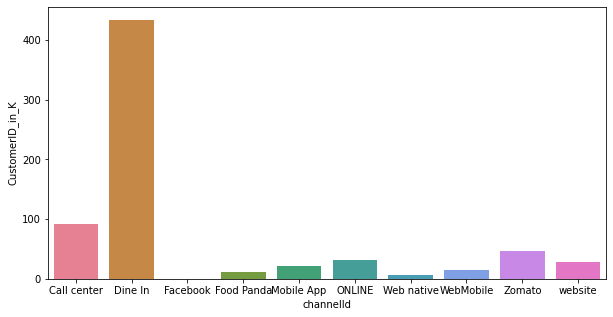

In [ ]:
plt.figure(figsize=(10, 5))
s = sns.barplot(x="channelId", y="CustomerID_in_K", data=trans_unique_df, palette="husl") # Thousand scale

#### Number of city per channelId

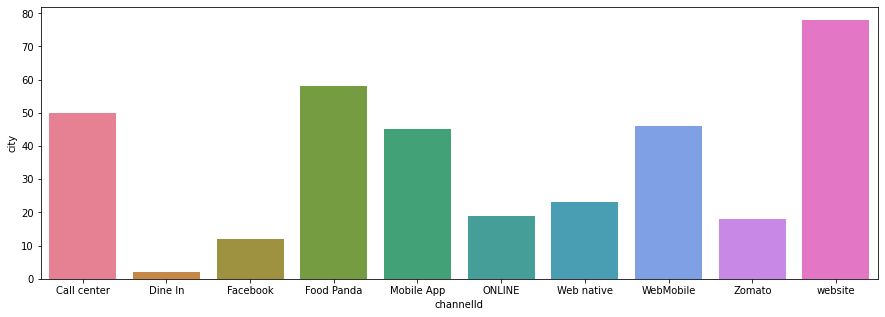

In [ ]:
plt.figure(figsize=(15, 5))
s = sns.barplot(x="channelId", y="city", data=trans_unique_df, palette="husl")

In [ ]:
trans_df.loc[trans_df.channelId == 'Dine In'].city.unique()

array([nan, 'MUMBAI', 'PUNE'], dtype=object)

#### Total Amount per channelId

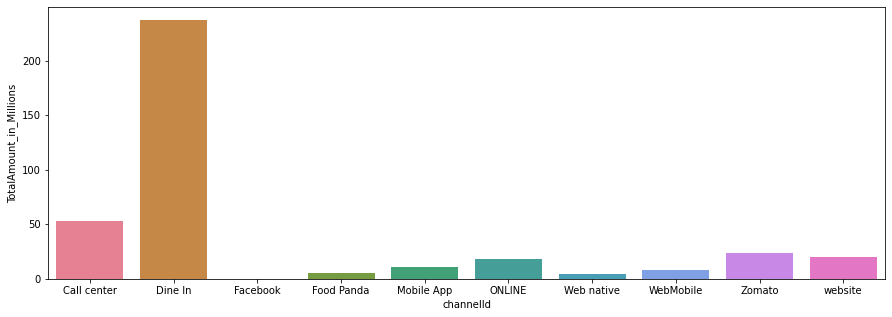

In [ ]:
plt.figure(figsize=(15, 5))
s = sns.barplot(x="channelId", y="TotalAmount_in_Millions", data=trans_unique_df, palette="husl")

#### Profit per channelId

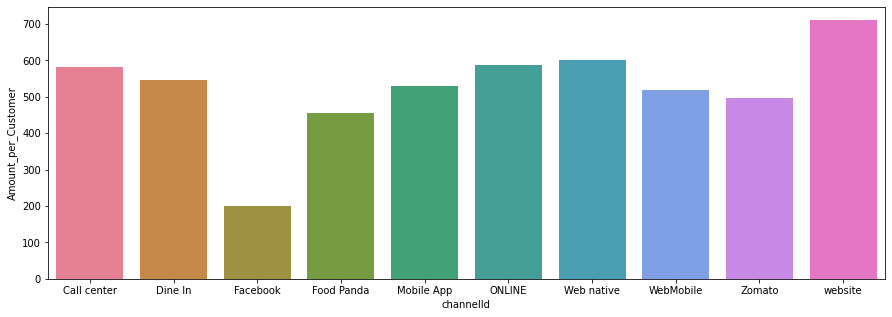

In [ ]:
plt.figure(figsize=(15, 5))
s = sns.barplot(x="channelId", y="Amount_per_Customer", data=trans_unique_df, palette="husl")

In [ ]:
trans_unique_df.sort_values(by='Amount_per_Customer', ascending=False).reset_index().drop('index', axis=1)

,channelId,CustomerID,Transaction_date,city,TotalAmount,TotalAmount_in_Millions,CustomerID_in_K,Amount_per_Customer
0,website,27612,57,78,1.963641e+07,19.636410,27.612,711.154917
1,Web native,6993,55,23,4.194191e+06,4.194191,6.993,599.769949
2,ONLINE,31434,57,19,1.842041e+07,18.420414,31.434,586.002855
3,Call center,91756,57,50,5.330150e+07,53.301502,91.756,580.904814
4,Dine In,433819,57,2,2.372935e+08,237.293510,433.819,546.987360
5,Mobile App,20934,57,45,1.107092e+07,11.070924,20.934,528.848951
6,WebMobile,14951,57,46,7.749776e+06,7.749776,14.951,518.344980
7,Zomato,46775,57,18,2.328972e+07,23.289724,46.775,497.909646
8,Food Panda,11050,57,58,5.031186e+06,5.031186,11.050,455.310954
9,Facebook,18,15,12,3.608910e+03,0.003609,0.018,200.495000


### Datewise Customers per Channel

In [ ]:
temp_channel_date_df = trans_df.groupby(['Transaction_date', 'channelId']).agg({'CustomerID': 'count'}).reset_index()
temp_channel_date_df['Weekday'] = temp_channel_date_df.Transaction_date.dt.strftime('%A')
temp_channel_date_df

,Transaction_date,channelId,CustomerID,Weekday
0,2018-05-01,Call center,1552,Tuesday
1,2018-05-01,Dine In,8033,Tuesday
2,2018-05-01,Food Panda,262,Tuesday
3,2018-05-01,Mobile App,402,Tuesday
4,2018-05-01,ONLINE,417,Tuesday
...,...,...,...,...
521,2018-06-30,ONLINE,898,Saturday
522,2018-06-30,Web native,122,Saturday
523,2018-06-30,WebMobile,269,Saturday
524,2018-06-30,Zomato,878,Saturday


#### Date vs Customers

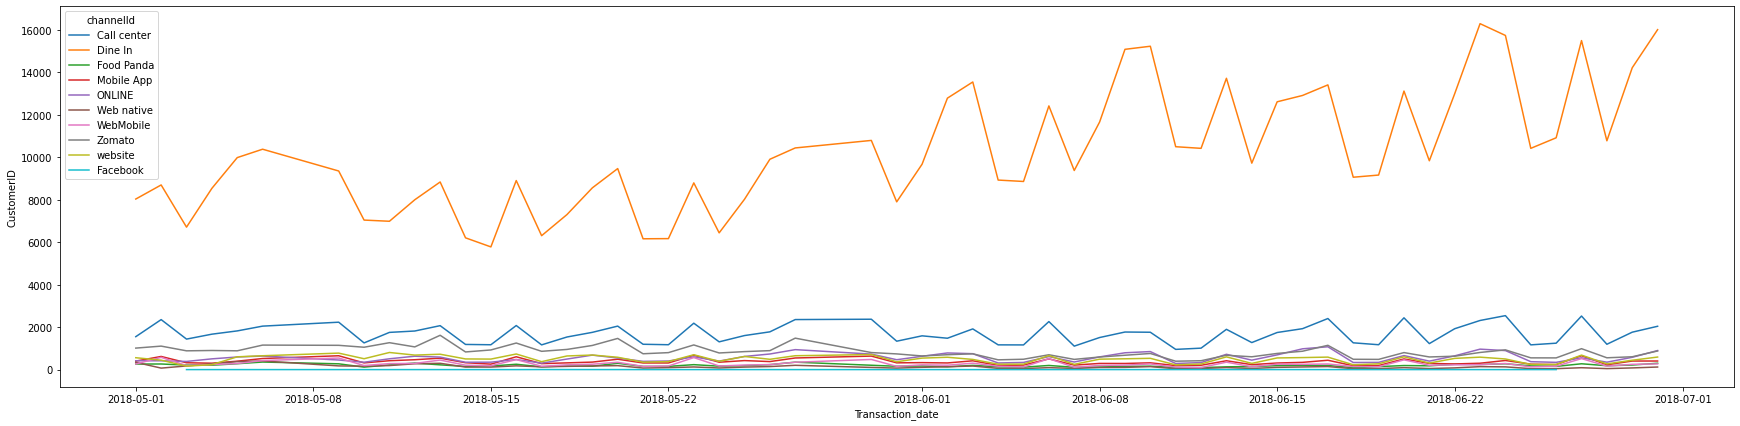

In [ ]:
plt.figure(figsize=(30, 7))
sns.lineplot(data=temp_channel_date_df, x=temp_channel_date_df['Transaction_date'].dt.date, y='CustomerID', hue='channelId')

#### Weekdays vs Customers

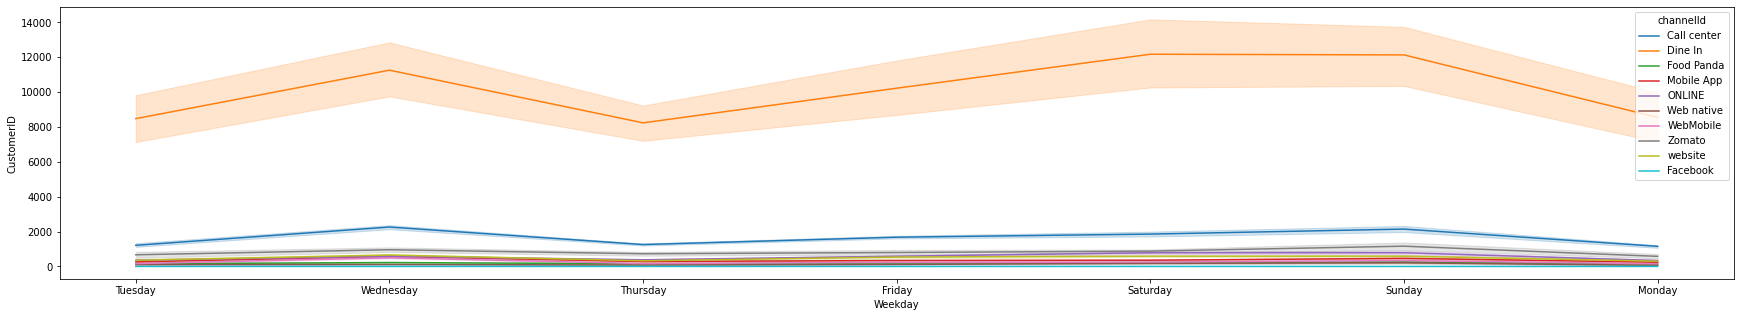

In [ ]:
plt.figure(figsize=(30, 5))
sns.lineplot(data=temp_channel_date_df, x='Weekday', y='CustomerID', hue='channelId')

### Insights

- 63.69% CustomerID has 2 GuestcheckId and rest have 1 GuestcheckId - IMPORTANT
- Transaction_date and Last_update_date is same
- Out of 10 channelId only one channelId (Dine in) is offline
- Dine in channel has largest number of customers and Facebook has lowest - IMPORTANT
- Dine in has largest amount and Facebook has lowest - IMPORTANT
- Dine in is operated only in two cities - Mumbai and Pune - IMPORTANT
- Most profitable channelId is website and Dine in comes at 5th number. Facebook is lowest profitable. - IMPORTANT
- Over a period of time number of customers keep increasing for Dine in channel
- Customers order more on Wednesday, Saturday and Sunday - IMPORTANT

### Queries

- On what column should we merge the Product and Transaction data as some of the values are missing for Check Ids?

### Pending

## Transaction with Product data

In [ ]:
product_df.head(2)

,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date
0,9870XXXX53606,711863273,HYDERABAD/SECUNDERABAD,0171-6208991 WebMobile,84258674,310128,14 May 18
1,9870XXXX51763,716686990,NaN,NaN,84258093,310128,27 May 18


In [ ]:
trans_df.head(2)

,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount
0,386191,727585634,NaN,23 Jun 18,9821XXXX691,23 Jun 18,Dine In,2506,200.34
1,111063,721708340,MOHALI,8 Jun 18,9821XXXX718,8 Jun 18,Mobile App,7499,234.30


### Common Check id data in Transaction and Product data

#### Number of common check id

In [ ]:
product_check_id = set(product_df.CHECK_ID.unique())
trans_check_id = set(trans_df.GuestcheckId.unique())
print('Number of unique check id in product data: ', len(product_check_id))
print('Number of unique check id in trans data: ', len(trans_check_id))
print('Number of unique common check id in product and trans data: ', len(product_check_id.intersection(trans_check_id)))

Number of unique check id in product data:  59154
Number of unique check id in trans data:  846369
Number of unique common check id in product and trans data:  32379


#### Product data for check ids found in Transaction data

In [ ]:
common_product_df = product_df.loc[product_df.CHECK_ID.isin(trans_df.GuestcheckId)]
print("Number of rows : ", len(common_product_df))
common_product_df.head(2)

Number of rows :  32379


,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date
0,9870XXXX53606,711863273,HYDERABAD/SECUNDERABAD,0171-6208991 WebMobile,84258674,310128,14 May 18
1,9870XXXX51763,716686990,NaN,NaN,84258093,310128,27 May 18


#### Product data for check ids not found in Transaction data

In [ ]:
uncommon_product_df = product_df.loc[~product_df.CHECK_ID.isin(trans_df.GuestcheckId)]
print("Number of rows : ", len(uncommon_product_df))
uncommon_product_df.head(2)

Number of rows :  26775


,CONTACT_NUMBER,CHECK_ID,city,ONLINE_ORDER_TYPE,recordID,menuItemPOSRef,Actual Date
3,9870XXXX51767,703695102,BENGALURU/BANGALORE,0081-5957166 WebMobile,84258800,310128,23 Apr 18
8,9870XXXX51773,700725006,NaN,NaN,84256415,310128,15 Apr 18


#### Transaction data for check ids found in Product data

In [ ]:
common_trans_df = trans_df.loc[trans_df.GuestcheckId.isin(product_df.CHECK_ID)]
print("Number of rows : ", len(common_trans_df))
common_trans_df.head(2)

Number of rows :  32379


,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount
493191,168960,711863273,HYDERABAD,14 May 18,9821XXXX520,14 May 18,WebMobile,8462,663.99
493205,352295,716686990,NaN,27 May 18,9821XXXX572,27 May 18,Dine In,8301,809.69


#### Transaction data for check ids not found in Product data

In [ ]:
uncommon_trans_df = trans_df.loc[~trans_df.GuestcheckId.isin(product_df.CHECK_ID)]
print("Number of rows : ", len(uncommon_trans_df))
uncommon_trans_df.head(2)

Number of rows :  813990


,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount
0,386191,727585634,NaN,23 Jun 18,9821XXXX691,23 Jun 18,Dine In,2506,200.34
1,111063,721708340,MOHALI,8 Jun 18,9821XXXX718,8 Jun 18,Mobile App,7499,234.30


## Conclusion

**Insights**

- 35% data is missing for column ONLINE_ORDER_TYPE in Product data
- Need to know understanding of recordID
- 54.73% of Product Check Ids found in Transaction data
- Only 3.82% of Transaction Guest Check Ids found in Product data
- There are 7 channels in the data 
- CONTACT_NUMBER and CHECK_ID is one to one mapping - IMPORTANT
- Except CONTACT_NUMBER and CHECK_ID all other columns are repeated
- 64.88% CHECK_ID has only one ONLINE_ORDER_TYPE_text i.e one-to-one mapping present in the data  - IMPORTANT
- We don't know ONLINE_ORDER_TYPE_text for 35.11% of CHECK_ID
- ONLINE_ORDER_TYPE has 2 fields - Contact number and Order type. Contact number could be different for different areas in the same city.
- 63.69% CustomerID has 2 GuestcheckId and rest have 1 GuestcheckId - IMPORTANT
- Transaction_date and Last_update_date is same
- Out of 10 channelId only one channelId (Dine in) is offline
- Dine in channel has largest number of customers and Facebook has lowest - IMPORTANT
- Dine in has largest amount and Facebook has lowest - IMPORTANT
- Dine in is operated only in two cities - Mumbai and Pune - IMPORTANT
- Most profitable channelId is website and Dine in comes at 5th number. Facebook is lowest profitable. - IMPORTANT
- Over a period of time number of customers keep increasing for Dine in channel
- Customers order more on Wednesday, Saturday and Sunday - IMPORTANT